# 郵送最適化
- 実際の物流 Data から Network 構造を可視化する方法。
- 最適な物流計画を立案する

In [1]:
import pandas as pd

# 生産工場の Data
factories = pd.read_csv('sample_code/chapter_6/tbl_factory.csv', index_col=0)
factories

,FCName,FCDemand,FCRegion
FCID,,,
FC00001,東京工場,28,関東
FC00002,木更津工場,29,関東
FC00003,多摩工場,31,関東
FC00004,横須賀工場,25,関東
FC00005,仙台工場,21,東北
FC00006,山形工場,30,東北
FC00007,那須工場,25,東北
FC00008,青森工場,16,東北


In [2]:
# 倉庫の Data
warehouses = pd.read_csv('sample_code/chapter_6/tbl_warehouse.csv', index_col=0)
warehouses

,WHName,WHSupply,WHRegion
WHID,,,
WH00001,杉並倉庫,35,関東
WH00002,品川倉庫,41,関東
WH00003,豊洲倉庫,42,関東
WH00004,郡山倉庫,60,東北
WH00005,仙台倉庫,72,東北
WH00006,山形倉庫,65,東北


In [3]:
# 倉庫と工場間の輸送 Cost
cost = pd.read_csv('sample_code/chapter_6/rel_cost.csv', index_col=0)
cost.head()

,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4
2,FC00001,WH00002,0.8
3,FC00001,WH00003,1.5
4,FC00002,WH00001,0.9
5,FC00002,WH00002,0.8


In [4]:
# 2019年の工場への部品輸送実績
trans = pd.read_csv('sample_code/chapter_6/tbl_transaction.csv', index_col=0)
trans.head()

,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2019-01-01 06:32:32,FC00006,WH00004,31
3,2019-01-01 07:17:06,FC00002,WH00003,18
4,2019-01-01 07:52:18,FC00001,WH00002,30


### 工場 & 倉庫 Data
- 工場 Data(factories)の「FCID」
- 倉庫 Data(warehouses)の「WHID」

は、Cost data と輸送実績(trans) data にも登場しているので Key と判断する。

### Cost data
工場 Data と倉庫 Data の組み合わせ毎の Cost が管理されている。

### 輸送実績 Data
- 実際の輸送日時(TransactionDate)
- 輸送先工場(ToFC)
- 輸送元倉庫(FromWH)
- 輸送個数(Quantity)

が Log として保持されている。

Data 分析の基礎となるべき Data は輸送実績(trans)と判断し、主体として各 Data を結合(Left join)していく。

In [5]:
# trans data を主に cost data を結合
join_data = pd.merge(trans, cost, left_on=['ToFC', 'FromWH'], right_on=['FCID', 'WHID'], how='left')
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8


In [6]:
# factories data を 結合
join_data = pd.merge(join_data, factories, left_on='ToFC', right_on='FCID', how='left')
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,関東
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,那須工場,25,東北
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,山形工場,30,東北
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,木更津工場,29,関東
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,東京工場,28,関東


In [7]:
# warehouses data を結合
join_data = pd.merge(join_data, warehouses, left_on='FromWH', right_on='WHID', how='left')
join_data = join_data[['TransactionDate', 'Quantity', 'Cost', 'ToFC', 'FCName', 'FCDemand', 'FromWH', 'WHName',
                       'WHSupply', 'WHRegion']]  # 並びを変更して視認性をあげる
join_data.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東


関東支社と東北支社の Data を比較する

In [8]:
kanto = join_data.loc[join_data['WHRegion'] == '関東']
kanto.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東
7,2019-01-01 09:09:30,12,1.5,FC00001,東京工場,28,WH00003,豊洲倉庫,42,関東
8,2019-01-01 10:52:55,27,1.5,FC00003,多摩工場,31,WH00003,豊洲倉庫,42,関東


In [9]:
tohoku = join_data.loc[join_data['WHRegion'] == '東北']
tohoku.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
5,2019-01-01 08:56:09,31,0.3,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北
6,2019-01-01 09:00:15,33,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
9,2019-01-01 14:12:51,21,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北


実際の輸送量や掛かっている Cost を確認し、支社間で比較していく。

In [10]:
print(f'関東支社の総コスト{str(kanto["Cost"].sum())}万円')
print(f'東北支社の総コスト{str(tohoku["Cost"].sum())}万円')

関東支社の総コスト2189.3万円
東北支社の総コスト2062.0万円


関東支社の方が東北支社よりも輸送 Cost の総額が多くかかっていることがわかる。

In [11]:
print(f'関東支社の層部品輸送個数: {str(kanto["Quantity"].sum())}個')
print(f'東北支社の層部品輸送個数: {str(tohoku["Quantity"].sum())}個')

関東支社の層部品輸送個数: 49146個
東北支社の層部品輸送個数: 50214個


関東支社より東北支社の方が多くの部品を輸送していることがわかる。

In [12]:
tmp = (kanto['Cost'].sum() / kanto['Quantity'].sum()) * 10_000
print(f'関東支社の部品１つ当たりの輸送 Cost: {str(int(tmp))}円')
tmp = (tohoku['Cost'].sum() / tohoku['Quantity'].sum()) * 10_000
print(f'東北支社の部品１つ当たりの輸送 Cost: {str(int(tmp))}円')

関東支社の部品１つ当たりの輸送 Cost: 445円
東北支社の部品１つ当たりの輸送 Cost: 410円


当然、東北支社の１つ当たりの輸送 Cost が低い。

In [13]:
cost_chk = pd.merge(cost, factories, on='FCID', how='left')
print(f'東京支社の平均輸送 Cost: {str(cost_chk["Cost"].loc[cost_chk["FCRegion"] == "関東"].mean())}万円')
print(f'東北支社の平均輸送 Cost: {str(cost_chk["Cost"].loc[cost_chk["FCRegion"] == "東北"].mean())}万円')

東京支社の平均輸送 Cost: 1.075万円
東北支社の平均輸送 Cost: 1.05万円


各支社の平均輸送 Cost はほぼ同じ。
集計の結果、東北支社の方が関東支社よりも**効率よく**部品の輸送が行えている。

In [14]:
# Data の読み込み
df_tr = pd.read_csv('sample_code/chapter_6/trans_route.csv', index_col='工場')
df_tr.head()

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


### 施策
現状、どの倉庫からどの工場へ、どれだけの量の輸送が行われているのかを記録を確認。

### 結果
数値だけでは、全体像を想像するのが容易ではない為、Network 可視化を利用して輸送 Route を可視化する。

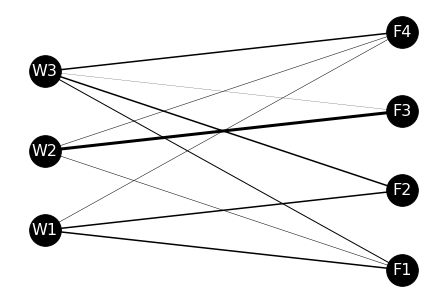

In [16]:
import matplotlib.pyplot as plt
import networkx as nx

# Data の読み込み
df_tr = pd.read_csv('sample_code/chapter_6/trans_route.csv', index_col="工場")
df_pos = pd.read_csv('sample_code/chapter_6/trans_route_pos.csv')


# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 辺の設定&エッジの重みのリスト化
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            # 辺の追加
            G.add_edge(df_pos.columns[i],df_pos.columns[j])
            # エッジの重みの追加
            if num_pre<len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                elif(df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)
                

# 座標の設定
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])
    
# 描画
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

# 表示
plt.show()

どの倉庫からどの工場へも、まんべんなく **link** (輸送 Route)が見える。
輸送 Cost を考えると、輸送 Route はある程度集約していった方が、効率が良いと思われる。

In [ ]:
# Data を読み込み
df_tr = pd.read_csv('sample_code/chapter_6/trans_route.csv', index_col='工場')
df_tc = pd.read_csv('sample_code/chapter_6/trans_cost.csv', index_col='工場')


# 輸送 Cost 関数
def trans_cost(df_tr, df_tc):
    cost = 0
    for i in range(len(df_tc.index)):
        for j in range(len(df_tr.columns)):
            cost += df_tr.iloc[i][j] * df_tc.iloc[i][j]
    return cost


print(f'総輸送 Cost: {str(trans_cost(df_tr, df_tc))}')

In [ ]:
# Data の読み込み
df_tr = pd.read_csv('sample_code/chapter_6/trans_route.csv', index_col='工場')
df_demand = pd.read_csv('sample_code/chapter_6/demand.csv')
df_supply = pd.read_csv('sample_code/chapter_6/supply.csv')

# 需要側の制約条件
for i in range(len(df_demand.columns)):
    temp_sum = sum(df_tr[df_demand.columns[i]])
    print(f'{str(df_demand.columns[i])}への輸送量: {str(temp_sum)}(需要量: {str(df_demand.iloc[0][i])})')
    if temp_sum >= df_demand.iloc[0][i]:
        print('需要量を満たしています。')
    else:
        print('需要量を満たしていません。輸送 Route を再計算して下さい。')

# 供給側の制約条件
for i in range(len(df_supply.columns)):
    temp_sum = sum(df_tr.loc[df_supply.columns[i]])
    print(f'{str(df_supply.columns[i])}からの輸送量: {str(temp_sum)}(供給限界: {str(df_supply.iloc[0][i])})')
    if temp_sum <= df_supply.iloc[0][i]:
        print('供給限界の範囲内です。')
    else:
        print('供給限界を超過しています。輸送 Route を再計算して下さい。')

## 制約条件
### 工場で製造される製品の数が需要量を満たすかどうか
各工場に運び込まれる部品の数と、各工場に対する需要量を比較することで検討可能。
### 倉庫から工場に出荷される部品数が、倉庫の供給限界を超えるかどうか
各倉庫から出荷される部品の数と、各倉庫の供給限界とを比較することで検討可能。

この制約条件を作っておくことで、輸送 Route を変更した後に、新しい Route が制約条件を満たすかどうか確認できる。

In [ ]:
import numpy as np

# Data の読み込み
df_tr_new = pd.read_csv('sample_code/chapter_6/trans_route_new.csv', index_col='工場')
print(df_tr_new)

# 総輸送 Cost 再計算
print(f'総輸送 Cost (変更後): {str(trans_cost(dt_tr_new, df_tc))}')


# 制約条件計算関数
# 需要側
def condition_demand(dt_tr, df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum >= df_demand.iloc[0][i]):
            flag[i] = 1
    return flag


# 供給側
def condition_supply(df_tr, df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum <= df_supply.iloc[0][i]:
            flag[i] = 1
    return flag


print(f'需要条件計算結果: {str(condition_demand(df_tr_new, df_demand))}')
print(f'供給条件計算結果: {str(condition_supply(df_tr_new, df_supply))}')

### 今回の輸送 Route
工場 W1 から F4 への輸送を減らし、その分を工場 W2 からF4 への輸送で補う Route
もとの輸送 Cost よりも若干の Cost cut は見込めるが、２番目の供給条件が満たせておらず W2 からの供給限界を超えてしまっている。